1. Скачать видео:
https://www.youtube.com/watch?v=NdSqAAT28v0

In [ ]:
import os
!yt-dlp 'https://www.youtube.com/watch?v=NdSqAAT28v0' -o 'video.webm'

2. Средствами библиотек Python извлечь из видео кадры (в оригинале извлекался каждый третий кадр).

In [74]:
import cv2

vidcap = cv2.VideoCapture('video.webm')

In [75]:
import os

os.makedirs('video_frames', exist_ok=True)

frame_margin = 3

success, image = vidcap.read()
count = 1
alt_count = 1
while success:
    if count % frame_margin == 0:
        cv2.imwrite(os.path.join("video_frames", f"image_{alt_count}.png"), image)
        alt_count += 1
    success, image = vidcap.read()
    count += 1


3. Средствами библиотек Python преобразовать разрешение кадров 1920x1080 -> 96x54 (можно другое соотношение).

In [ ]:
import cv2, os
import numpy as np

os.makedirs('video_frames_small', exist_ok=True)
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
for image_name in os.listdir('video_frames'):
    image = cv2.imread(os.path.join('video_frames', image_name))
    image = cv2.filter2D(image, kernel=kernel, ddepth=-5)
    image = cv2.resize(image, (96, 54))
    cv2.imwrite(os.path.join("video_frames_small", image_name), image)

4. Средствами библиотек Python перевести в черно-белое изображение (белый фон, черная фигура)

In [1]:
import cv2, os
import numpy as np

os.makedirs('video_frames_bw', exist_ok=True)
for image_name in os.listdir('video_frames_small'):
    image = cv2.imread(os.path.join('video_frames_small', image_name), 1)
    tmp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(tmp, 5, 255, cv2.THRESH_BINARY)
    image[alpha.astype(bool), :] = [255, 255, 255]
    image[np.logical_not(alpha.astype(bool)), :] = [0, 0, 0]

    cv2.imwrite(os.path.join("video_frames_bw", image_name), image)

ModuleNotFoundError: No module named 'cv2'

5. Обучить в Pytorch автоэнкодер (с помощью полносвязных слоев или, как в видео, сверточных) так, чтобы каждое изображение кодировалось вектором длины 128.

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [4]:
images = []
for image_name in os.listdir("video_frames_bw"):
    image_full_path = os.path.join("video_frames_bw", image_name)
    image = cv2.imread(image_full_path)[:, :, 1]
    images.append(image)
images = np.array(images)

In [5]:
from keras import layers
from keras import models

IMAGE_SHAPE = (54, 96)


def build_autoencoder_parts(img_shape, code_size):
    # The encoder
    encoder = models.Sequential()
    encoder.add(layers.InputLayer(img_shape))
    encoder.add(layers.Flatten()),
    encoder.add(layers.Dense(512, activation='relu'))
    encoder.add(layers.Dense(code_size))

    # The decoder
    decoder = models.Sequential()
    decoder.add(layers.InputLayer((code_size,)))
    decoder.add(layers.Dense(512, activation='relu'))
    decoder.add(layers.Dense(np.prod(img_shape)))
    decoder.add(layers.Reshape(img_shape))

    return encoder, decoder


def build_auto_encoder(img_shape, encoder, decoder):
    inp = layers.Input(img_shape)
    code = encoder(inp)
    reconstruction = decoder(code)

    auto_encoder = models.Model(inp, reconstruction)
    auto_encoder.compile(optimizer='adamax', loss='mse')
    return auto_encoder


encoder, decoder = build_autoencoder_parts(IMAGE_SHAPE, 128)
auto_encoder = build_auto_encoder(IMAGE_SHAPE, encoder, decoder)

2024-06-06 12:28:42.894209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 12:28:43.975375: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 12:28:43.979769: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 12:28:4

In [6]:
history = auto_encoder.fit(x=images, y=images, epochs=20)

Epoch 1/20


I0000 00:00:1717676929.801068      70 service.cc:145] XLA service 0x722ff0004370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717676929.801098      70 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-06-06 12:28:49.848884: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-06 12:28:49.963606: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1717676931.188716     112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_336', 48 bytes spill stores, 48 bytes spill loads

I0000 00:00:1717676931.600917     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_368', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00

 152/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 10447.5605

I0000 00:00:1717676933.980005      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1454/1499 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 3738.3584

I0000 00:00:1717676937.569561     265 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_336', 64 bytes spill stores, 64 bytes spill loads



1499/1499 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3695.0818
Epoch 2/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - loss: 1541.0411
Epoch 3/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - loss: 1287.5894
Epoch 4/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - loss: 1181.1847
Epoch 5/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - loss: 1120.2256
Epoch 6/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - loss: 1079.9991
Epoch 7/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - loss: 1046.2390
Epoch 8/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - loss: 1016.9988
Epoch 9/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - loss: 993.0342
Epoch 10/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step - loss: 973.8177
Epoch 11/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - loss: 959.9858
Epoch 12/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - loss: 947.5546
Epoch 13/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - loss: 932.3957
Epoch 14/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 958us

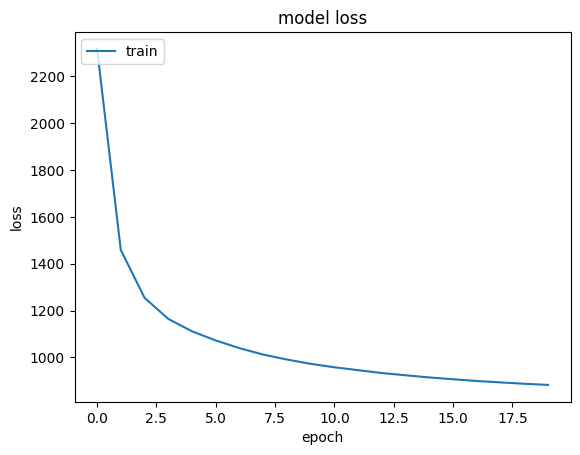

In [7]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


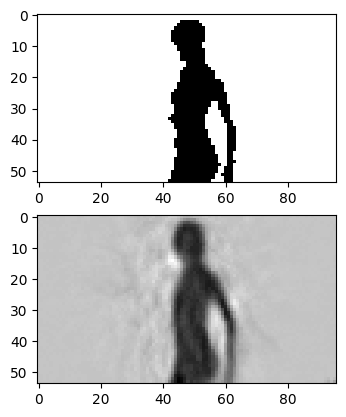

In [11]:
import matplotlib.pyplot as plt

test_image = cv2.imread('video_frames_bw/image_400.png')[:, :, 1]

plt.subplot(2, 1, 1)
plt.imshow(test_image, cmap="gray")

predicted = auto_encoder.predict(np.array([test_image]))

plt.subplot(2, 1, 2)
plt.imshow(predicted.reshape(54, 96), cmap="gray")


6. Перевести все изображения в последовательность 128-мерных векторов.

In [12]:
predicted = encoder.predict(np.array([test_image]))
predicted

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


array([[ 3.00370045e+01, -3.02637543e+02,  5.68430908e+02,
         2.17627090e+02,  2.59247925e+02,  8.27603683e+01,
        -8.18368435e+00, -2.13026714e+01, -3.03905518e+02,
         9.99993286e+01,  9.31635678e-01, -6.71603470e+01,
         1.52344238e+02, -4.27110062e+01, -3.53004074e+01,
         5.50800354e+02, -7.70242691e+01, -1.18603050e+02,
        -6.11655083e+01, -8.81858215e+01, -5.58216133e+01,
         2.80253265e+02,  1.18220810e+02, -2.58195312e+02,
         1.72702957e+02,  1.41687384e+01,  3.57278625e+02,
         2.36418442e+02,  3.06917816e+02,  1.46128555e+02,
        -6.46560913e+02, -2.19568344e+02,  3.42281464e+02,
        -3.61681915e+02, -6.93325806e+01, -3.79551010e+01,
         6.82531509e+01,  2.83854389e+01, -3.08013363e+01,
        -2.22778492e+01,  1.58753052e+02,  2.06982834e+02,
         3.53973694e+02,  5.11559296e+02,  1.01454792e+01,
        -4.44268188e+01,  3.19093384e+02, -1.39967285e+02,
        -1.68561996e+02, -8.21748810e+01, -1.99890869e+0

In [13]:
codes = encoder.predict(images)
codes

1499/1499 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step


array([[ -46.608437 , -308.38754  ,   34.372997 , ..., -143.9593   ,
         494.1913   , -864.2207   ],
       [  70.28022  , -247.34381  ,  321.81494  , ..., -121.39295  ,
         -59.037834 , -275.67603  ],
       [ -75.059555 , -127.429146 ,  243.8108   , ..., -212.53127  ,
         155.44696  , -142.4587   ],
       ...,
       [-127.35417  ,  -47.928688 ,  -82.20836  , ..., -147.19818  ,
         -62.580498 ,   78.59956  ],
       [ 166.01993  ,   -5.4857483,  654.38165  , ..., -123.08716  ,
        -359.45578  , -240.96948  ],
       [-296.17346  , -215.95201  ,  105.82631  , ...,   84.923065 ,
          59.16535  ,  204.70267  ]], dtype=float32)

In [15]:
np.savetxt("codes.csv", codes, delimiter=",")

7. Обучить рекуррентную нейронную сеть (подобрать параметры самостоятельно) предсказывать по текущему следующий вектор.

In [156]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [157]:
codes = np.genfromtxt('codes.csv', delimiter=',')

In [158]:
from keras import layers
from keras import models


def create_RNN():
    model = models.Sequential()
    model.add(layers.InputLayer((128, 1)))
    model.add(layers.SimpleRNN(128, activation='relu', return_sequences=True))
    model.add(layers.SimpleRNN(256, activation='relu', return_sequences=True))
    model.add(layers.SimpleRNN(128, activation='relu', return_sequences=True))
    model.add(layers.Dense(units=1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


rnn_model = create_RNN()

In [ ]:
history = rnn_model.fit(x=codes[1:], y=codes[:-1], epochs=50, batch_size=500)

Epoch 1/50


I0000 00:00:1717682660.586218   51836 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1717682660.853548   51839 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1717682661.180259   51837 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_94', 176 bytes spill stores, 180 bytes spill loads

I0000 00:00:1717682661.239651   51840 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_92', 176 bytes spill stores, 180 bytes spill loads

I0000 00:00:1717682663.149555   51844 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_92', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1717682663.364184   51846 

95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 52132.6953

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predicted = rnn_model.predict(np.array([codes[123]]))
predicted.reshape(128)

8. С помощью обученной сети сгенерировать последовательность векторов.

In [ ]:
previous = codes[4312]  # just random code
sequence = []
for i in range(1000):
    predicted = rnn_model.predict(np.array([previous]))
    previous = predicted.reshape(128)
    sequence.append(previous)

In [ ]:
np.savetxt("sequence.csv", sequence, delimiter=",")

9. Перевести с помощью декодера последовательность векторов в последовательность кадров.

In [ ]:
sequence = np.genfromtxt('sequence.csv', delimiter=',')

generated_img = decoder.predict(sequence)

In [ ]:
plt.imshow(generated_img[100], cmap="gray")

10. Средствами библиотек Python преобразовать кадры в видео.

In [ ]:
generated_img.shape

In [ ]:
import cv2
import numpy as np
import glob

frameSize = (96, 54)

out = cv2.VideoWriter('output_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 10, frameSize)

for img in generated_img:
    img = np.dstack((img,img,img)).astype(np.uint8)
    out.write(img)

out.release()